In [1]:
import numpy as np
from skimage import morphology
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

def apply_local_averaging(crack_widths, skeleton, distance_transform, neighborhood_size=3):
    """
    Apply local averaging on crack widths based on the skeleton and distance transform.
    This function allows for a dynamic adjustment of the neighborhood size.
    """
    # Calculate the offset based on the neighborhood size
    offset = neighborhood_size // 2

    # Initialize an output array for the averaged crack widths with the same shape as the distance transform
    averaged_crack_widths = np.zeros_like(distance_transform)
    
    # Iterate over each point in the skeleton
    for y, x in zip(*np.where(skeleton)):
        # Define the neighborhood based on the specified size
        neighborhood = distance_transform[max(0, y-offset):y+offset+1, max(0, x-offset):x+offset+1]
        
        # Calculate the average distance in this neighborhood, considering only non-zero distances
        mean_distance = np.mean(neighborhood[neighborhood > 0])
        
        # Set the averaged width in the corresponding location
        averaged_crack_widths[y, x] = mean_distance * 2  # Multiply by 2 to get the width
    
    # Extract the averaged crack widths where the skeleton exists
    averaged_crack_widths = averaged_crack_widths[skeleton]
    
    return averaged_crack_widths
def crack_width_measure(binary_image, display_results=True, save_path="high_res_crack_widths.png", scale_factor=1):
    binary_image = binary_image > 0
    skeleton = morphology.skeletonize(binary_image)
    distance_transform = distance_transform_edt(binary_image)
    skeleton_coords = np.where(skeleton)
    crack_widths = distance_transform[skeleton] * 2
    averaged_crack_widths = apply_local_averaging(crack_widths, skeleton, distance_transform, neighborhood_size=3)
    averaged_crack_widths_mm = averaged_crack_widths * 0.568 / scale_factor

    if averaged_crack_widths_mm.size > 0:
        max_crack_width_mm = np.max(averaged_crack_widths_mm)
    else:
        max_crack_width_mm = 0

    if display_results:
        plot_and_save_results(binary_image, skeleton, averaged_crack_widths_mm, save_path)

    # Added skeleton_coords to return statement
    return averaged_crack_widths_mm, max_crack_width_mm, skeleton_coords
def plot_and_save_results(binary_image, skeleton, averaged_crack_widths_mm, save_path):
    plt.figure(figsize=(12, 12))
    plt.imshow(binary_image, cmap='gray')
    
    # Extract x and y coordinates from the skeleton
    y_coords, x_coords = np.where(skeleton)
    
    # Check if the length of averaged_crack_widths_mm matches the number of skeleton points
    if len(averaged_crack_widths_mm) != len(x_coords):
        raise ValueError("Mismatch between number of skeleton points and width data points.")
    
    # Correct plotting by passing x and y coordinates separately
    plt.scatter(x_coords, y_coords, c=averaged_crack_widths_mm, cmap='Reds', s=10, alpha=0.7, label='Avg. Crack Widths')
    plt.colorbar(label='Average Crack Width (mm)')
    plt.title('Average Crack Widths along Skeleton')
    plt.axis('off')
    
    plt.savefig(save_path, dpi=300)
    plt.show()

def analyse_crack_image(image_path, save_path="high_res_crack_widths.png", csv_save_path="crack_widths.csv", scale_factor=1):
    image = Image.open(image_path)
    image_array = np.array(image)
    binary_image = image_array > 0

    crack_widths, max_crack_width, skeleton_coords = crack_width_measure(binary_image, save_path=save_path, scale_factor=scale_factor)

    # Save to CSV
    import csv
    with open(csv_save_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['X Coordinate', 'Y Coordinate', 'Averaged Crack Width (mm)'])
        for x, y, width in zip(skeleton_coords[1], skeleton_coords[0], crack_widths):  # Note the reversed order for x, y
            writer.writerow([x, y, width])

    return crack_widths, max_crack_width


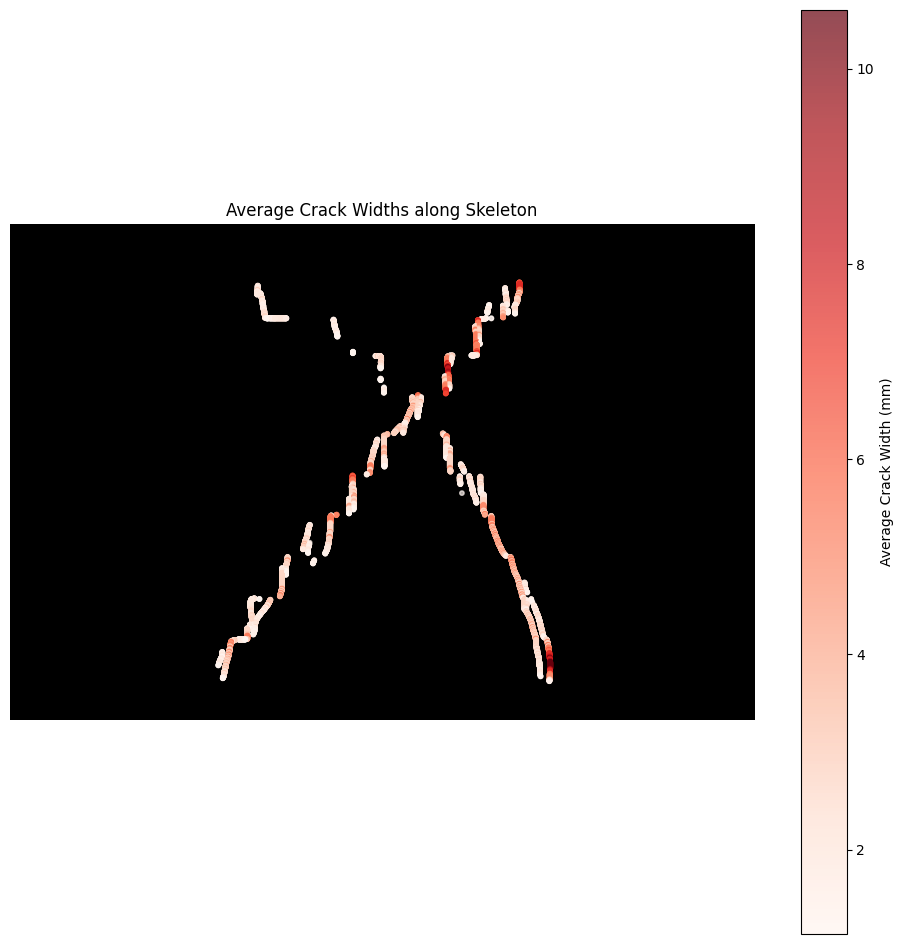

In [2]:
import os
crack_widths_mm, crack_width_measure_mm = analyse_crack_image(os.path.expanduser('../../segmented_speckled_for_width_comparison/SVS_1_MW0.1_LS22_to_LS23_078_0_class.tif'), save_path='proba.png', csv_save_path='SVS.csv')

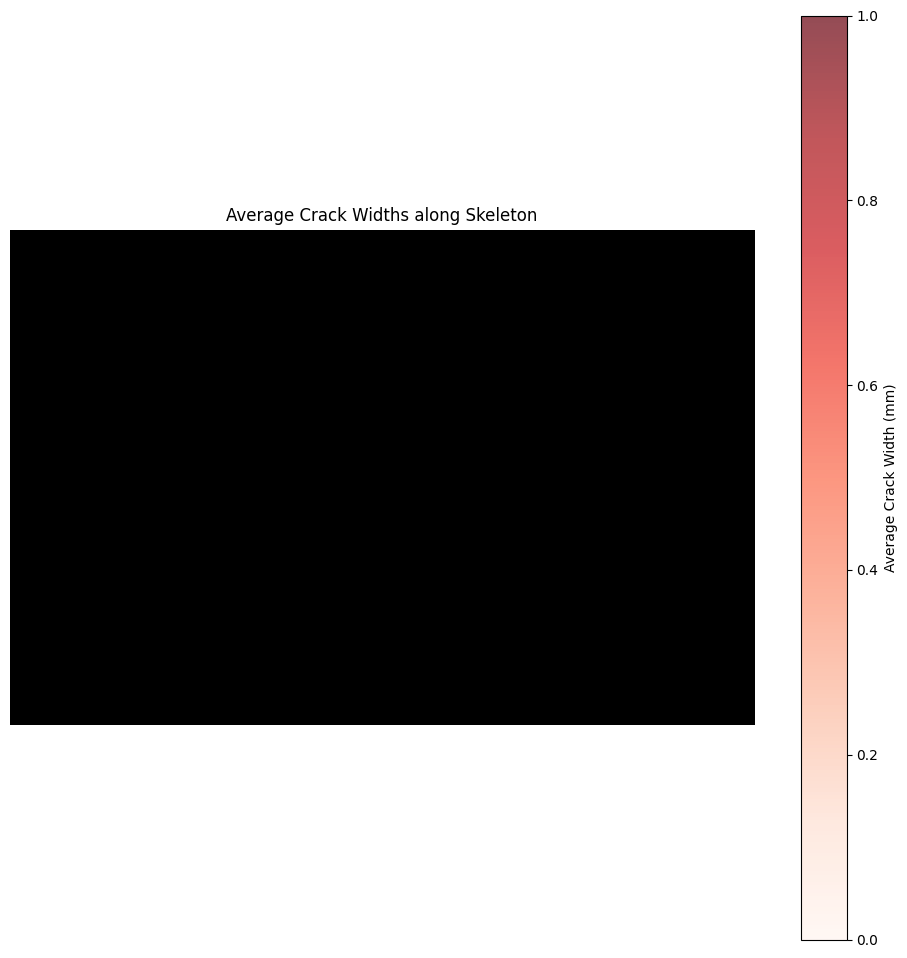

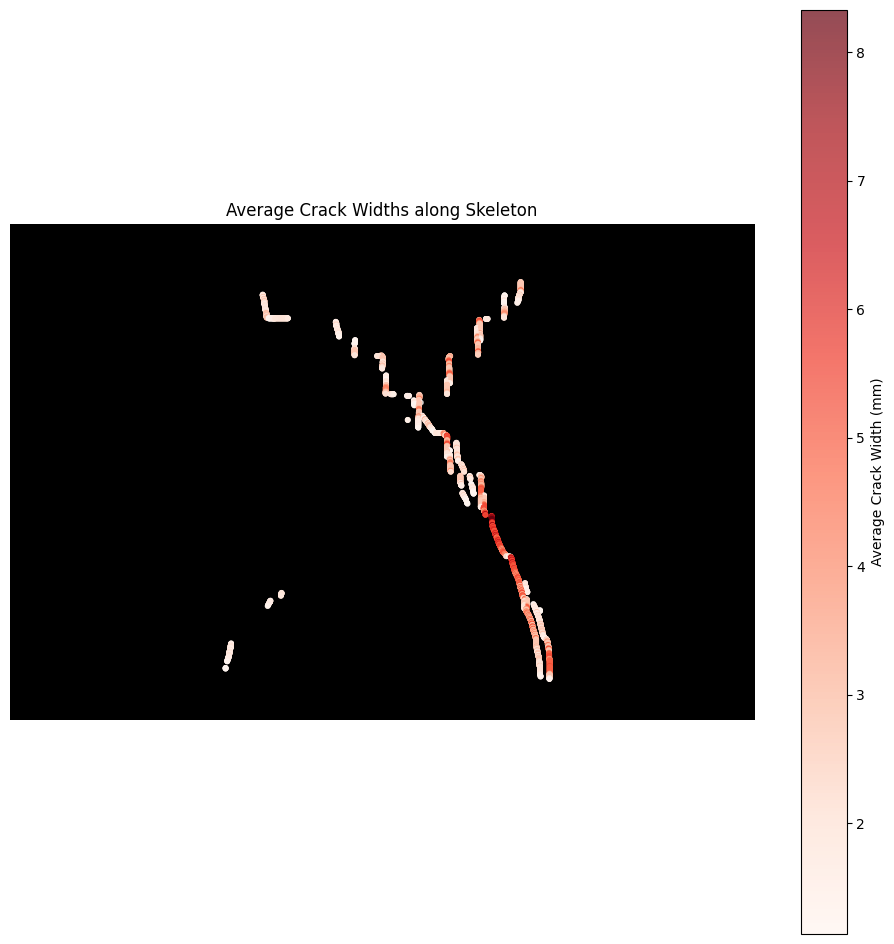

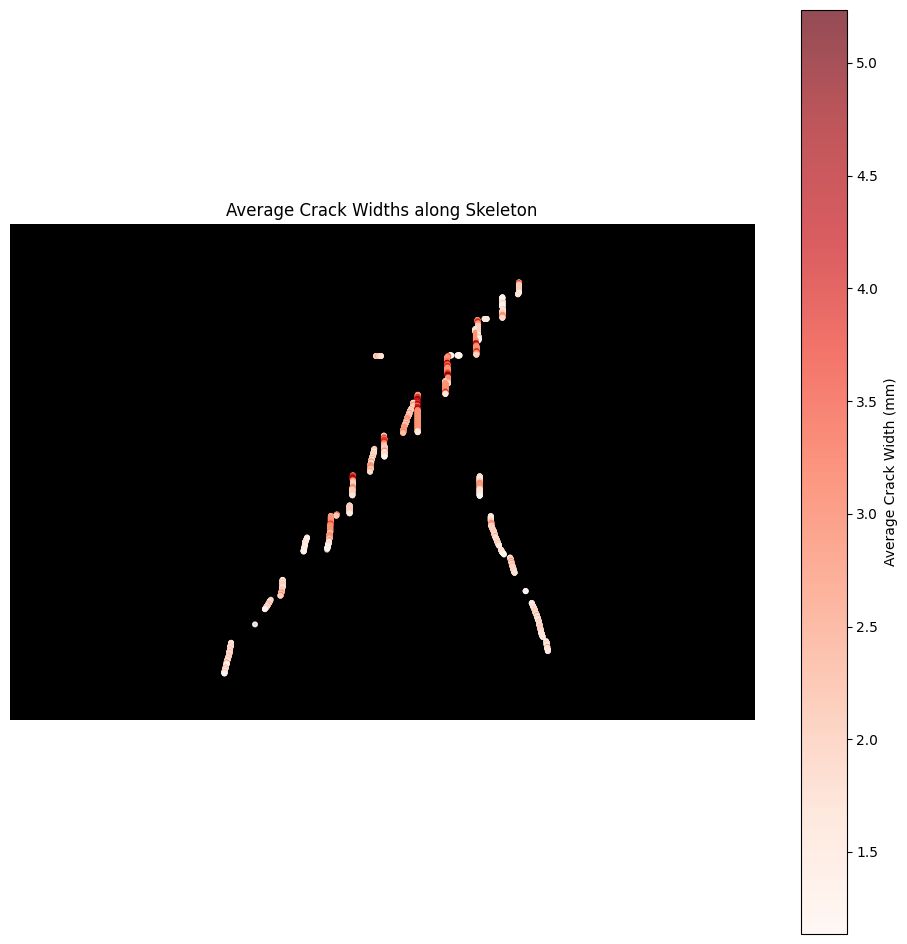

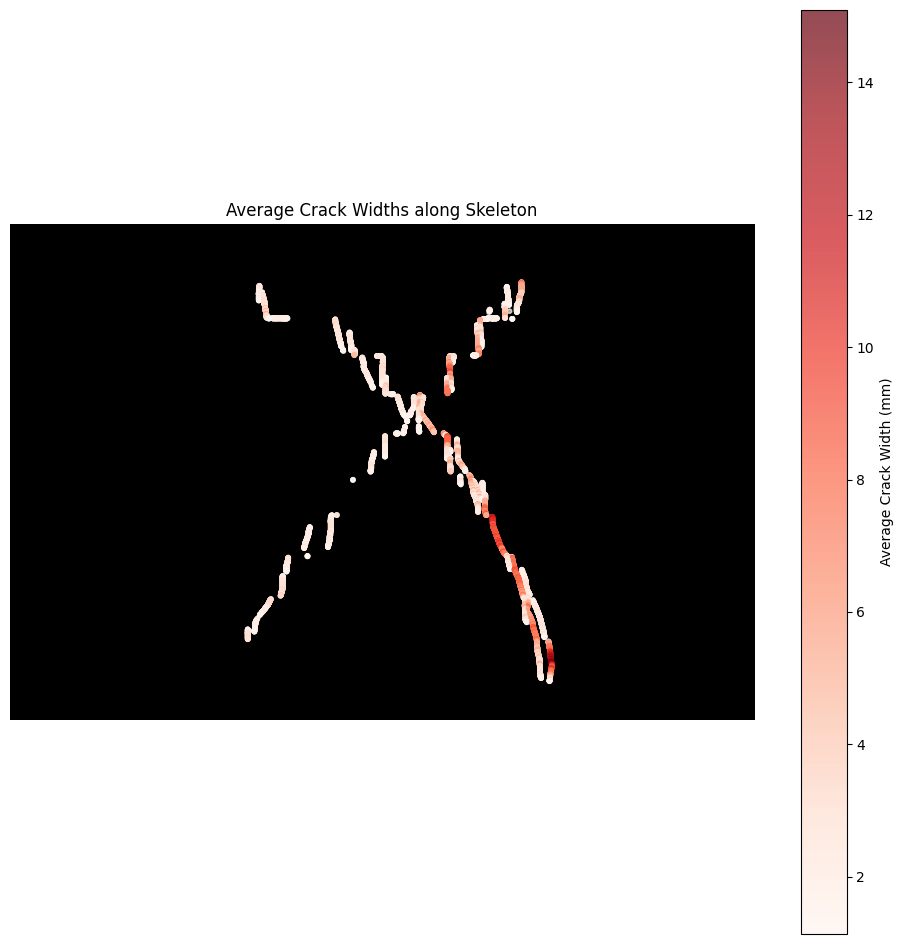

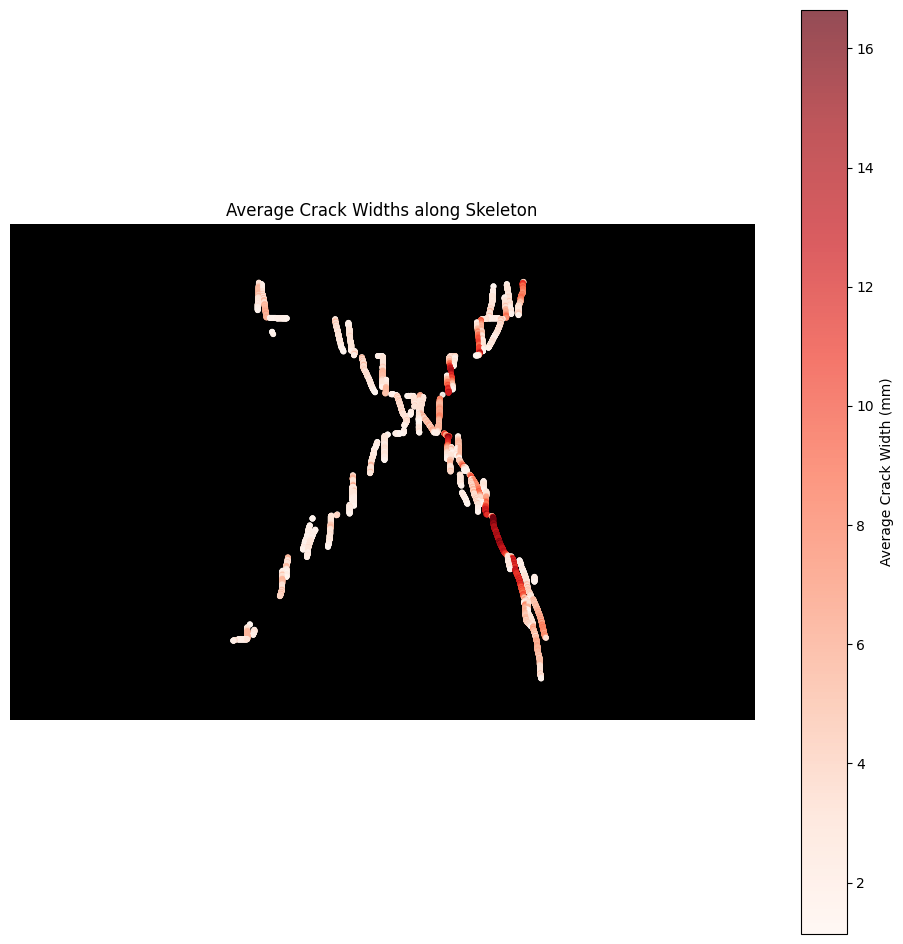

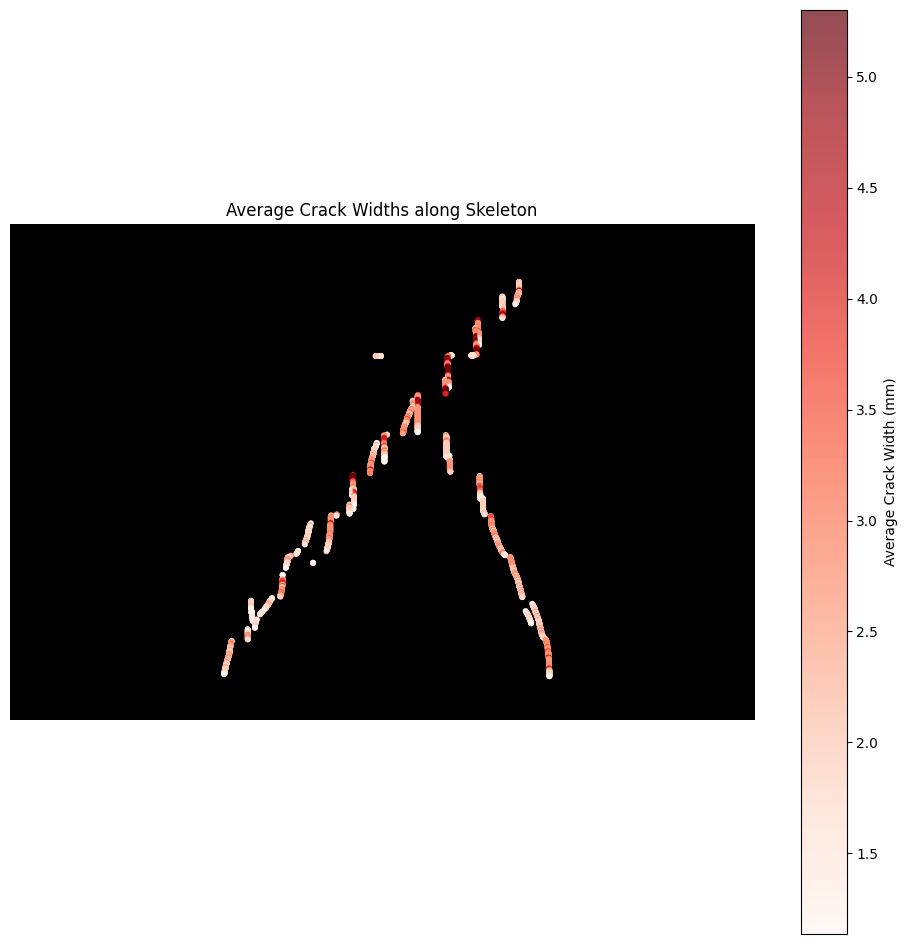

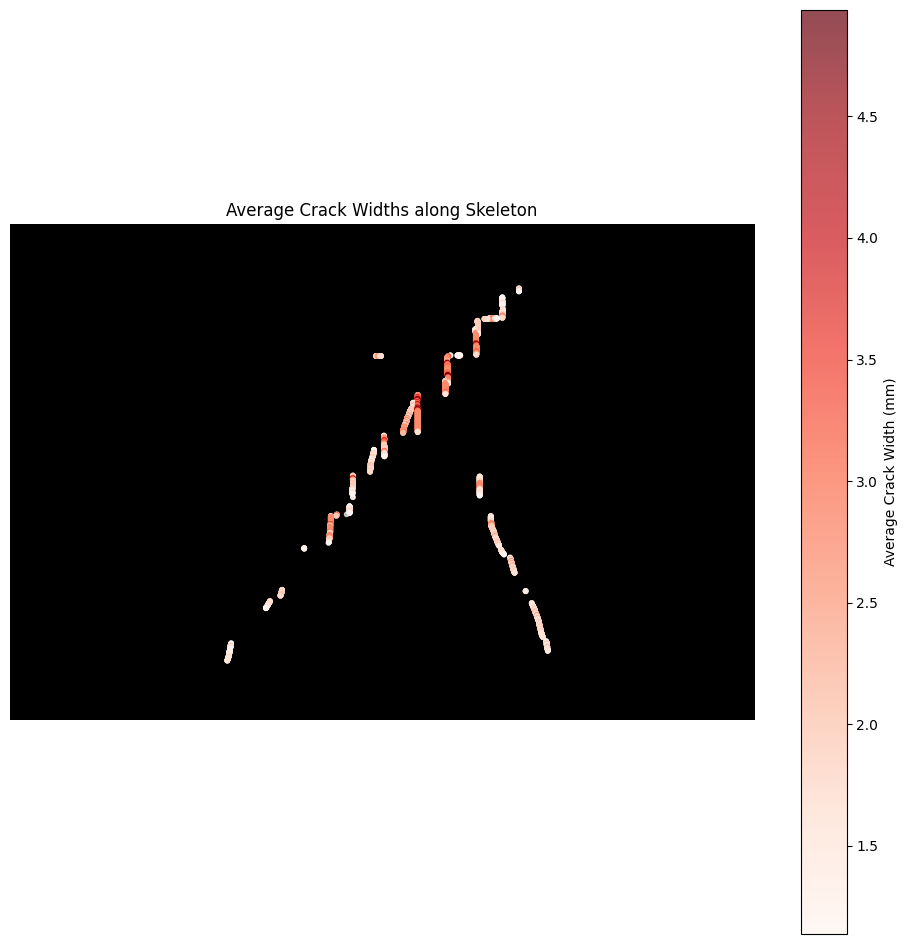

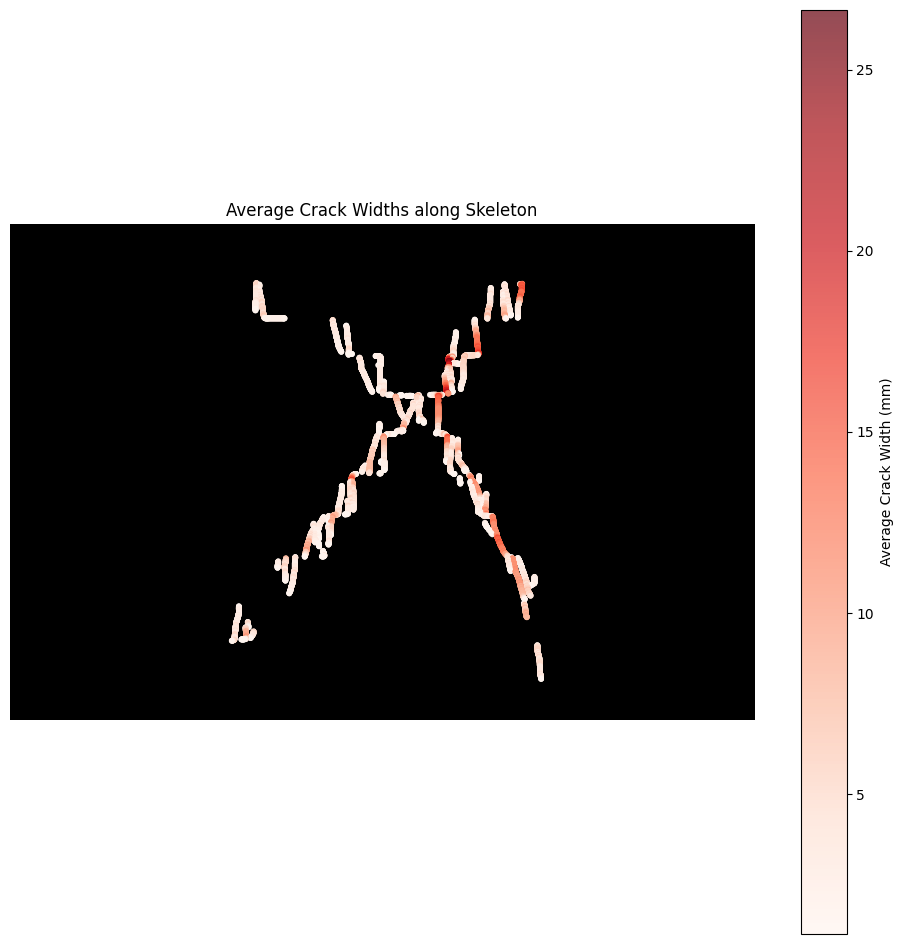

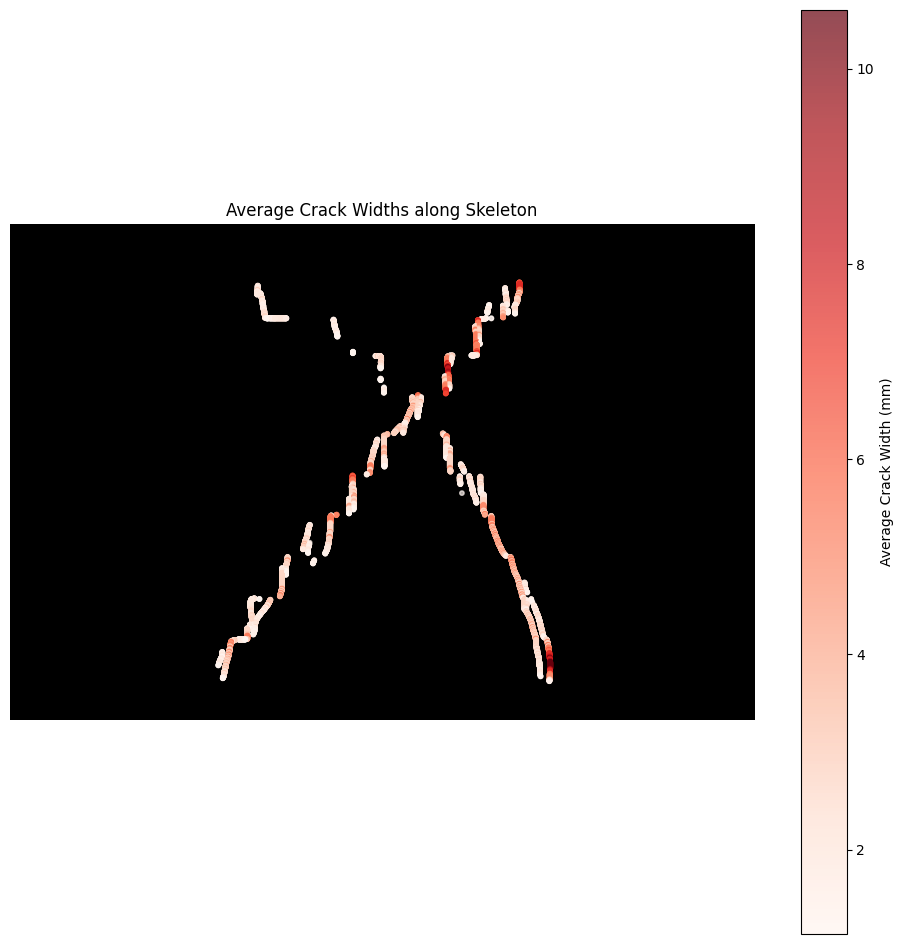

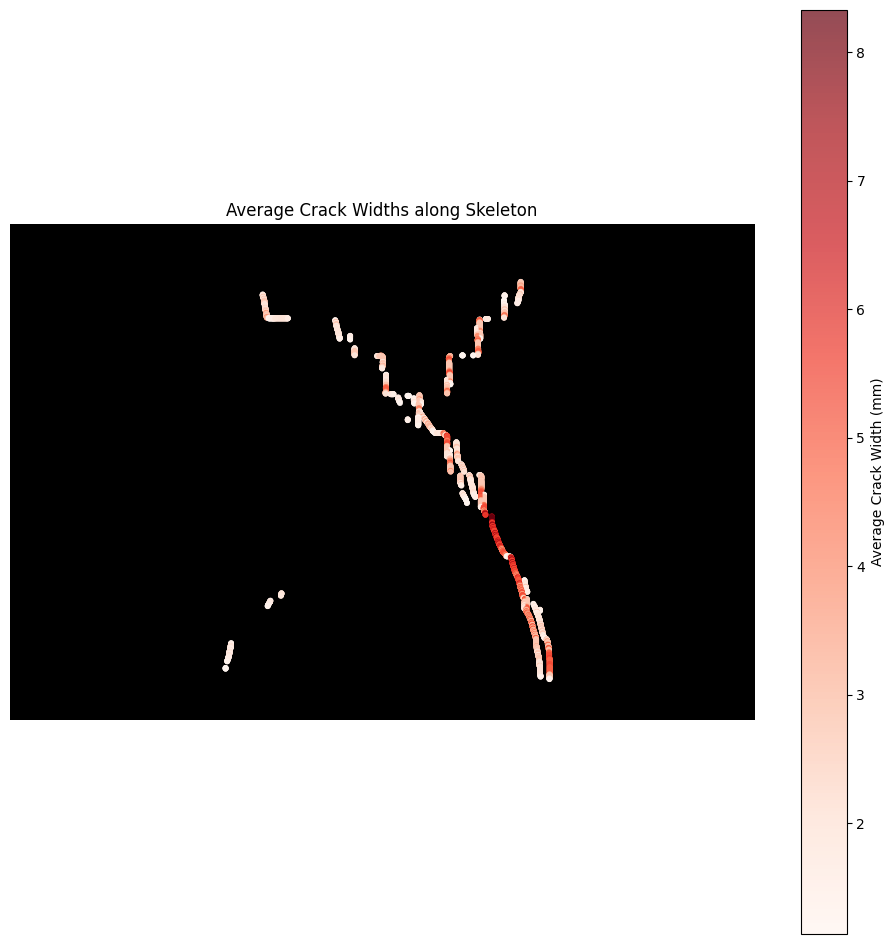

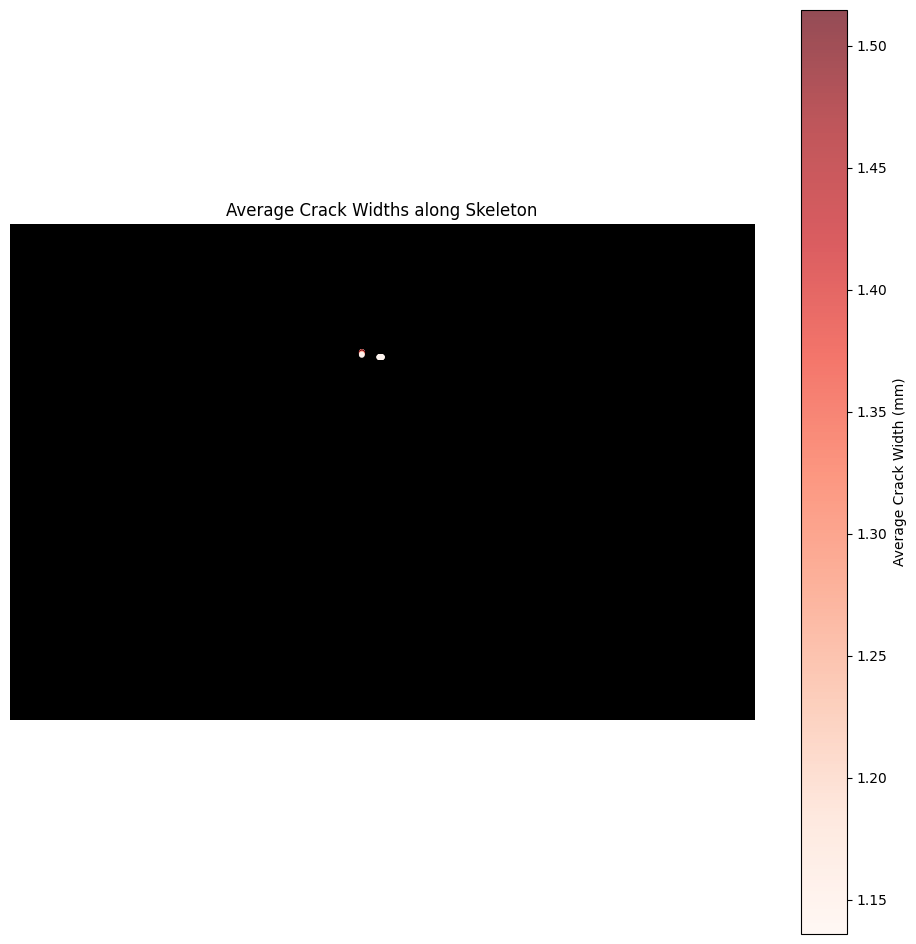

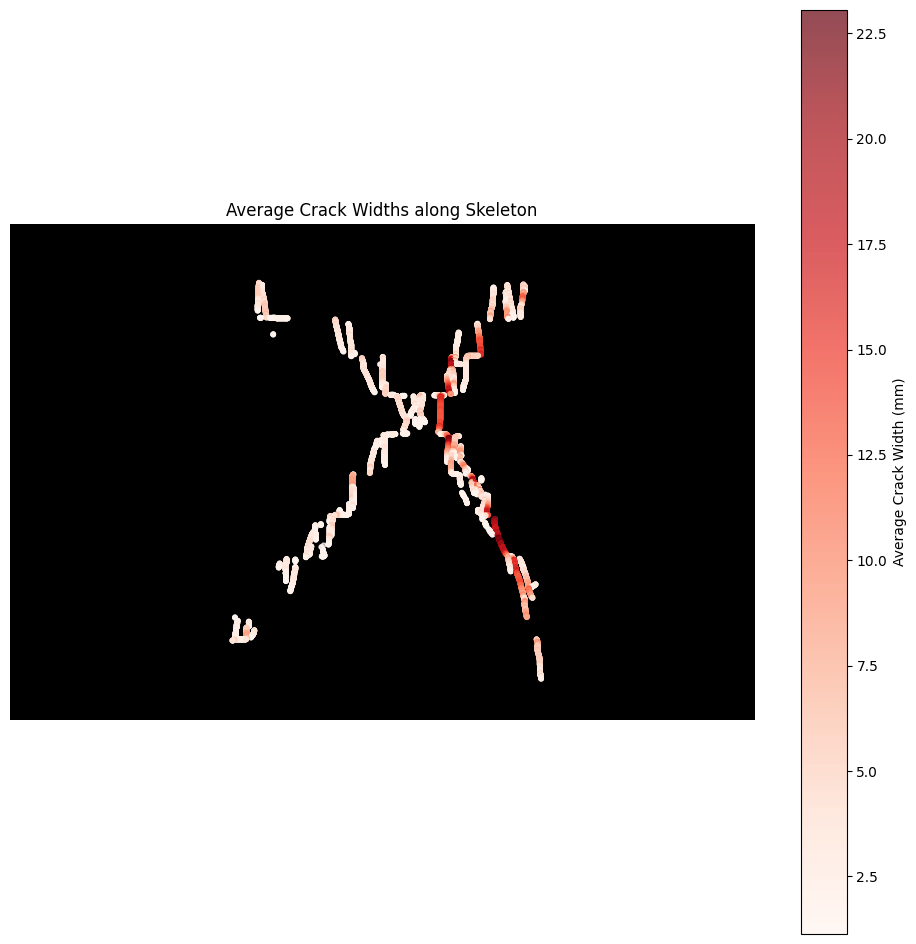

In [5]:
import os
import glob

# Define the directory containing the images
directory = os.path.expanduser('../../segmented_speckled_for_width_comparison')

# Find all '_class.tif' files in the specified directory
tif_files = glob.glob(os.path.join(directory, '*_class.tif'))

# Loop through each file found
for tif_file in tif_files:
    # Define the base filename to use for output files
    base_filename = os.path.splitext(os.path.basename(tif_file))[0]
    
    # Define paths for the output PNG and CSV files
    save_path = os.path.join(directory, f'{base_filename}.png')
    csv_save_path = os.path.join(directory, f'{base_filename}.csv')
    
    # Call your function to process the image and save the outputs
    analyse_crack_image(tif_file, save_path, csv_save_path)
